In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/franciszektokarek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_csv('../data/spam_ham_dataset.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [7]:
data.shape

(5171, 4)

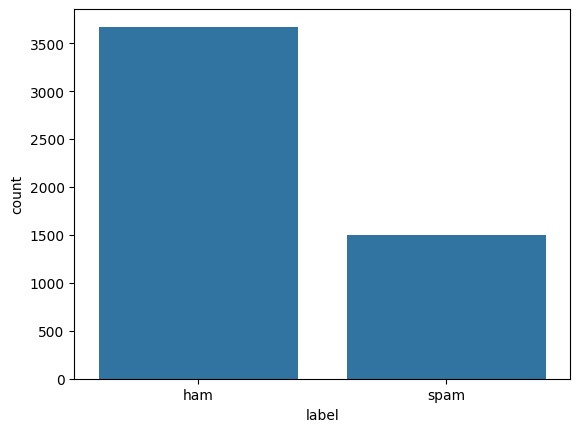

In [8]:
sns.countplot(x='label', data=data)
plt.show()

In [9]:
ham_msg = data[data['label'] == 'ham']
spam_msg = data[data['label'] == 'spam']

In [10]:
ham_msg_balanced = ham_msg.sample(n=len(spam_msg), random_state=42)

In [11]:
balanced_data = pd.concat([ham_msg_balanced, spam_msg]).reset_index(drop=True)

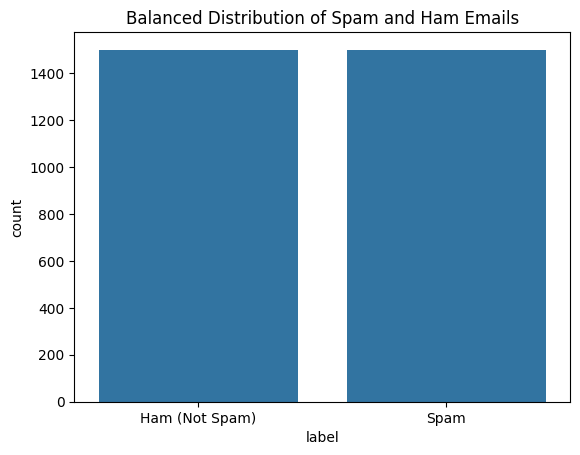

In [12]:
sns.countplot(x='label', data=balanced_data)
plt.title("Balanced Distribution of Spam and Ham Emails")
plt.xticks(ticks=[0, 1], labels=['Ham (Not Spam)', 'Spam'])
plt.show()

In [13]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,: conoco - big cowboy\r\ndarren :\r\ni ' m not...,0
1,2982,ham,: feb 01 prod : sale to teco gas processing\r\...,0
2,2711,ham,": california energy crisis\r\ncalifornia  , s...",0
3,3116,ham,: re : nom / actual volume for april 23 rd\r\n...,0
4,1314,ham,: eastrans nomination changes effective 8 / 2 ...,0


In [14]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

In [15]:
balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy\r\ndarren \r\ni m not sur...,0
1,2982,ham,feb 01 prod sale to teco gas processing\r\ns...,0
2,2711,ham,california energy crisis\r\ncalifornia  s p...,0
3,3116,ham,re nom actual volume for april 23 rd\r\nwe ...,0
4,1314,ham,eastrans nomination changes effective 8 2 0...,0


In [16]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output

In [17]:
balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy darren sure help know else a...,0
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2,2711,ham,california energy crisis california  power cr...,0
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


In [18]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} Emails', fontsize=15)
    plt.axis('off')
    plt.show()

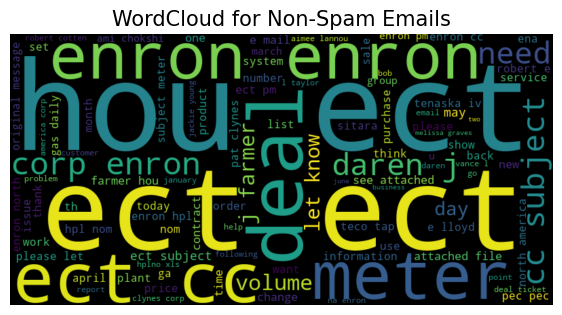

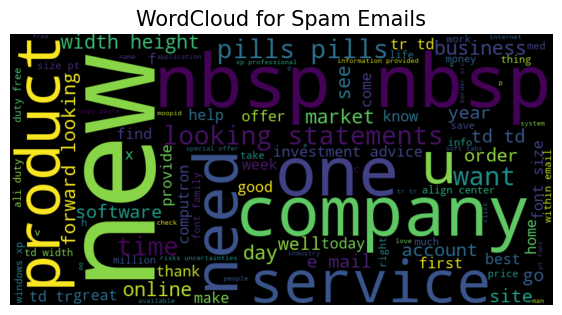

In [19]:
plot_word_cloud(balanced_data[balanced_data['label'] == 'ham'], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label'] == 'spam'], typ='Spam')

In [20]:
train_X, test_X, train_Y, test_Y = train_test_split(
    balanced_data['text'], balanced_data['label'], test_size=0.2, random_state=42
)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)
max_len = 100  # Maximum sequence length
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')
train_Y = (train_Y == 'spam').astype(int)
test_Y = (test_Y == 'spam').astype(int)

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

2025-10-20 16:50:20.312540: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-10-20 16:50:20.312798: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-20 16:50:20.312807: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-10-20 16:50:20.313021: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-20 16:50:20.313046: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)
history = model.fit(
    train_sequences, train_Y,
    validation_data=(test_sequences, test_Y),
    epochs=20,
    batch_size=32,
    callbacks=[lr, es]
)

Epoch 1/20


2025-10-20 16:58:20.494823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-10-20 16:58:20.508679: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.5242 - loss: 0.6913 - val_accuracy: 0.5683 - val_loss: 0.6771 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6681 - loss: 0.5982 - val_accuracy: 0.6417 - val_loss: 0.5788 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6897 - loss: 0.5397 - val_accuracy: 0.6633 - val_loss: 0.5322 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8540 - loss: 0.3048 - val_accuracy: 0.9633 - val_loss: 0.1537 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9604 - loss: 0.1710 - val_accuracy: 0.9600 - val_loss: 0.1606 - learning_rate: 0.0010
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9683 - loss: 0.1339 - val_accuracy: 0.9617 - val_loss: 0.1557 - learning_rate: 0.0010
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9712 - loss: 0.1218 - val_accuracy: 0.96

In [23]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9633 - loss: 0.1537
Test Loss : 0.1537339687347412
Test Accuracy : 0.9633333086967468


13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

2025-10-20 17:03:22.887029: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


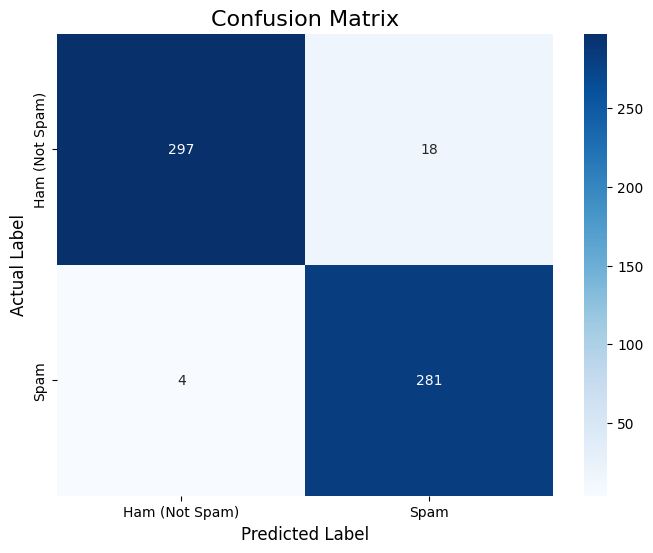


True Negatives: 297
False Positives: 18
False Negatives: 4
True Positives: 281


In [25]:
from sklearn.metrics import confusion_matrix

y_pred_prob = model.predict(test_sequences)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(test_Y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham (Not Spam)', 'Spam'], 
            yticklabels=['Ham (Not Spam)', 'Spam'])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

print(f'\nTrue Negatives: {cm[0][0]}')
print(f'False Positives: {cm[0][1]}')
print(f'False Negatives: {cm[1][0]}')
print(f'True Positives: {cm[1][1]}')


In [27]:
from sklearn.metrics import classification_report
print(classification_report(test_Y, y_pred, target_names=['Ham', 'Spam']))

              precision    recall  f1-score   support

         Ham       0.99      0.94      0.96       315
        Spam       0.94      0.99      0.96       285

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



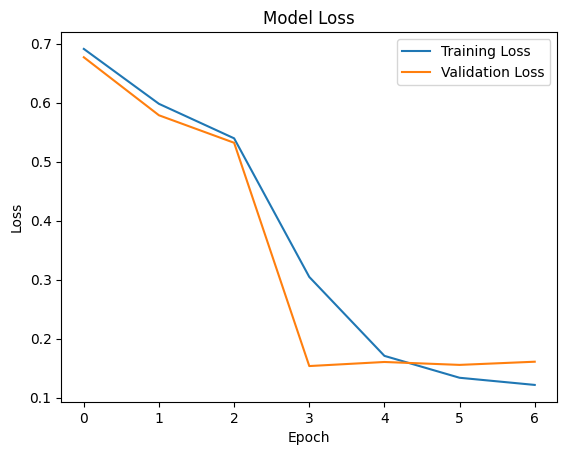

In [29]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [30]:
sample_indices = [0, 5, 10, 15, 20]
for idx in sample_indices:
    sample_text = test_X.iloc[idx]
    actual_label = 'Spam' if test_Y.iloc[idx] == 1 else 'Ham'
    
    sample_seq = tokenizer.texts_to_sequences([sample_text])
    sample_padded = pad_sequences(sample_seq, maxlen=max_len, padding='post', truncating='post')
    
    prediction_prob = model.predict(sample_padded, verbose=0)[0][0]
    predicted_label = 'Spam' if prediction_prob > 0.5 else 'Ham'
    
    print(f"\nEmail: {sample_text[:100]}...")
    print(f"Actual: {actual_label} | Predicted: {predicted_label} | Confidence: {prediction_prob:.4f}")



Email: october flow meter 982694 zavisch 2 measurement actuals first 14 days meter deal system wellhead pro...
Actual: Ham | Predicted: Ham | Confidence: 0.0106

Email: hpl nom march 13 2001 see attached file hplno 313 xls hplno 313 xls...
Actual: Ham | Predicted: Ham | Confidence: 0.0106

Email: get dell laptop computer free...
Actual: Spam | Predicted: Spam | Confidence: 0.9455

Email: cuold firned save 70 kind drugs quick ordering amd delivery fast free shipping order overnight shipp...
Actual: Spam | Predicted: Spam | Confidence: 0.9455

Email: vlc 0 dln sale prior pres crip tion needed enjoy 80 buy vlc 0 dln online get vla gra cla lls buy val...
Actual: Spam | Predicted: Spam | Confidence: 0.9455


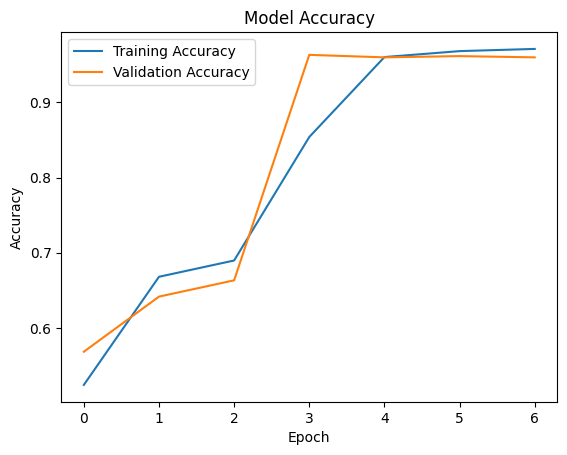

In [26]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()